In [1]:
import numpy as np
import emcee

import astropy.units as u
import pandas as pd

# Test fit of model generate dwith simulation 4 in the test set

In [2]:
backendfilename = 'backend_fitid89_wrms_allp_tune_corr_new_fixedslopeflaringcorr_log3_uncx10.h5'
name = backendfilename.split('.')[0]
n_walkers=70
id=89

In [3]:
val_params = pd.read_csv('../selected_val.csv', index_col=0)

In [4]:
val_params.loc[89]

InvStokes1      281.838293
Alpha             0.000813
AspectRatio       0.096150
FlaringIndex      0.071750
PlanetMass        0.006383
SigmaSlope        0.643500
nx              600.000000
rout              5.000000
ny              242.000000
maxder1500       56.195938
Name: 89, dtype: float64

In [5]:
__LABELS__ = ['Alpha', 'Aspect Ratio', 'PlanetMass', 'SigmaSlope', 'FlaringIndex', 'PlanetRadialPosition', 'PlanetAzimuthalPosition']
min_r = np.array([-4, 0.03, -5, 0.5, 0., 1,1])
max_r = np.array([-2, 0.1, -2, 1.2, 0.35, 1,1])
a = 2./(max_r-min_r)
b = -a*min_r -1
a[-2:] = [1,1]
b[-2:] = [0,0]

au_to_m = u.au.to('m')

log = [True, False, True, False, False, False, False]
def norm(data):
    new_data = data.copy()
    for i in range(data.shape[0]):
        if log[i]:
            new_data[i] = np.log10(data[i])
    return new_data*a+b

params_from_csv = val_params.loc[11, ['Alpha', 'AspectRatio', 'PlanetMass', 'SigmaSlope', 'FlaringIndex']]
target_params_nonorm = np.array([*params_from_csv, 400*au_to_m, np.pi/4])
target_params_norm = norm(target_params_nonorm)

par_ranges = [[1e-3, 1e-2], [0.03,0.1], [1e-4,1e-3], [0.5, 1.2], [0., 0.35], [300*au_to_m, 500*au_to_m], [-np.pi, np.pi]]

/tmp/ipykernel_23276/1522302106.py:4: RuntimeWarning: divide by zero encountered in divide
  a = 2./(max_r-min_r)


In [8]:
reader = emcee.backends.HDFBackend(backendfilename)

tau = reader.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(flat=True)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 171;
tau: [239.0216909  276.27995941 443.02976328 408.95254814 366.90526919
 414.05886703]

In [9]:
chain = reader.get_chain()
chain.shape

(8528, 70, 6)

In [12]:
chain = reader.get_chain()
chain = chain.reshape(-1,6)
chain2 = np.concatenate([chain, (chain[:,3]).reshape(-1,1)], axis=1)
chain = chain2[:, [0,1,2,6,3,4,5]]

In [13]:
target_params = target_params_norm

/home/aleruzza/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


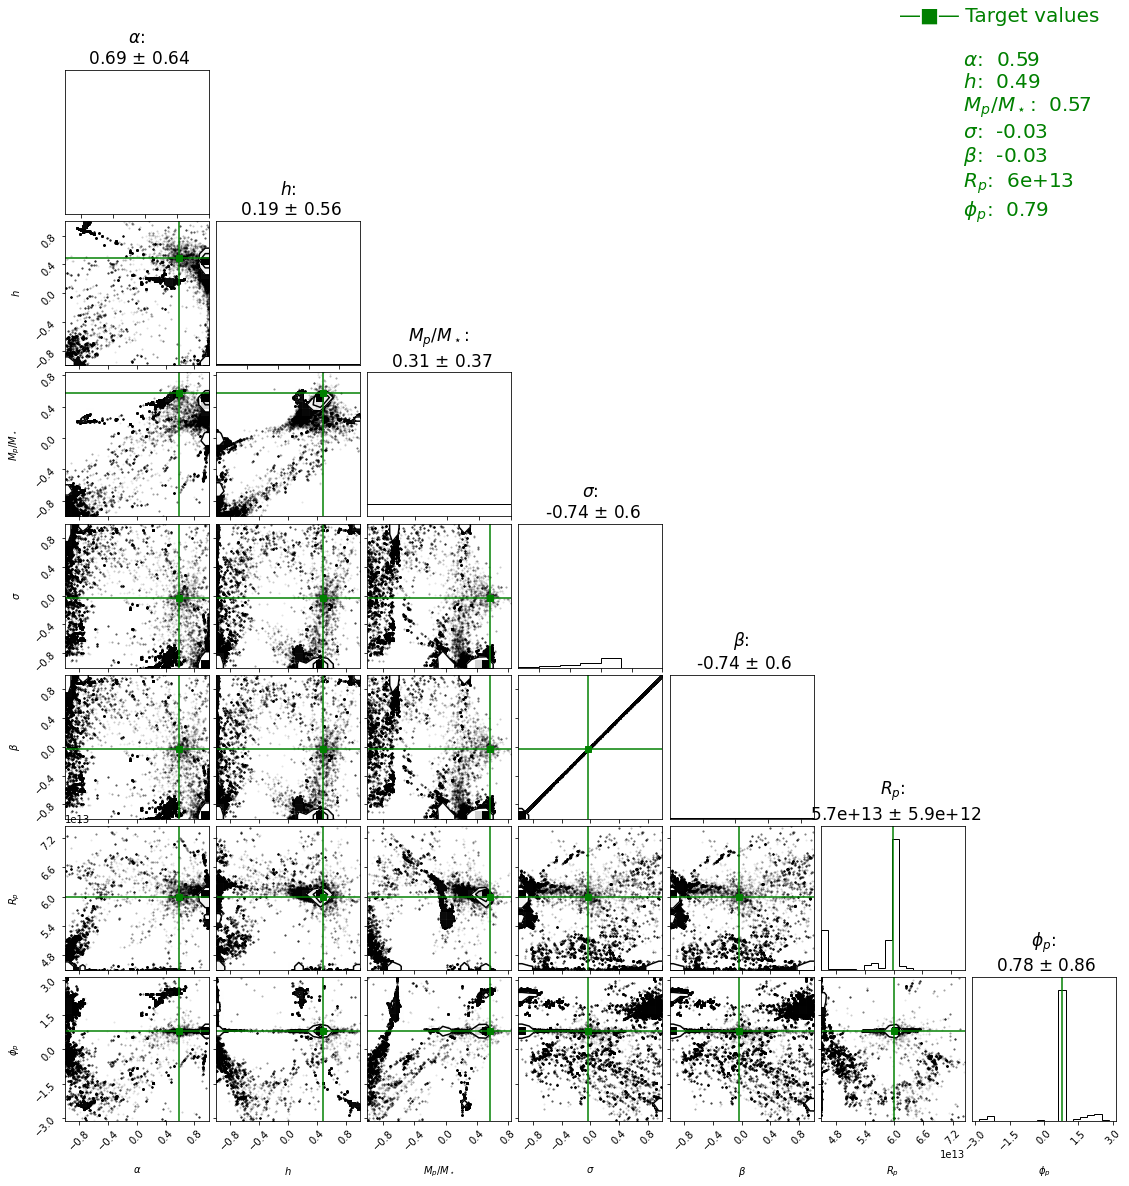

In [14]:
from corner import corner
import matplotlib.pyplot as plt
labels = ['$\\alpha$', '$h$', '$M_p/M_\\star$', '$\sigma$', '$\\beta$', '$R_p$', '$\phi_p$']
means = chain.reshape(-1,7).mean(axis=0)
stds = chain.reshape(-1,7).std(axis=0)
figure = corner(chain, labels=labels, fontsize=17)


# Extract the axes
axes = np.array(figure.axes).reshape((7,7))

# Loop over the diagonal
for i in range(7):
    ax = axes[i, i]
    ax.axvline(target_params[i], color="g")
    ax.set_xlim(par_ranges[i])
    ax.set_title(f'{labels[i]}:\n {means[i]:.2} $\pm$ {stds[i]:.2}', fontsize=17)

# Loop over the histograms
for yi in range(7):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(target_params[xi], color="g")
        ax.axhline(target_params[yi], color="g")
        ax.plot(target_params[xi], target_params[yi], "sg")
        
text = ''
for i, l in enumerate(labels):
    text = text + f'\t  {l}:  {target_params[i]:.2}\n'
axes[0,6].text(-0.5,-0.2,f'―■― Target values\n\n{text}', fontsize=20, color='g')
#plt.gcf().set_size_inches(7,7)
plt.savefig(f'{name}.png', dpi=500, bbox_inches='tight')

In [15]:
import matplotlib.pyplot as plt

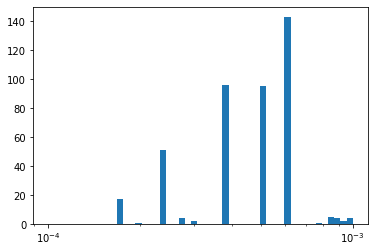

In [16]:
plt.hist(chain.reshape(-1), bins=np.logspace(-4,-3, 50))
plt.xscale('log')

# Acceptance rate

In [17]:
chain = chain.reshape(-1,n_walkers,7)
print(f'Acceptance rate: {reader.accepted.sum()/(chain.shape[0]*chain.shape[1])*100:.2f} %')

Acceptance rate: 19.83 %


In [18]:
chain[:, 1,0]

array([0.45424595, 0.43667423, 0.42610144, ..., 0.97943676, 0.97108881,
       0.96715952])

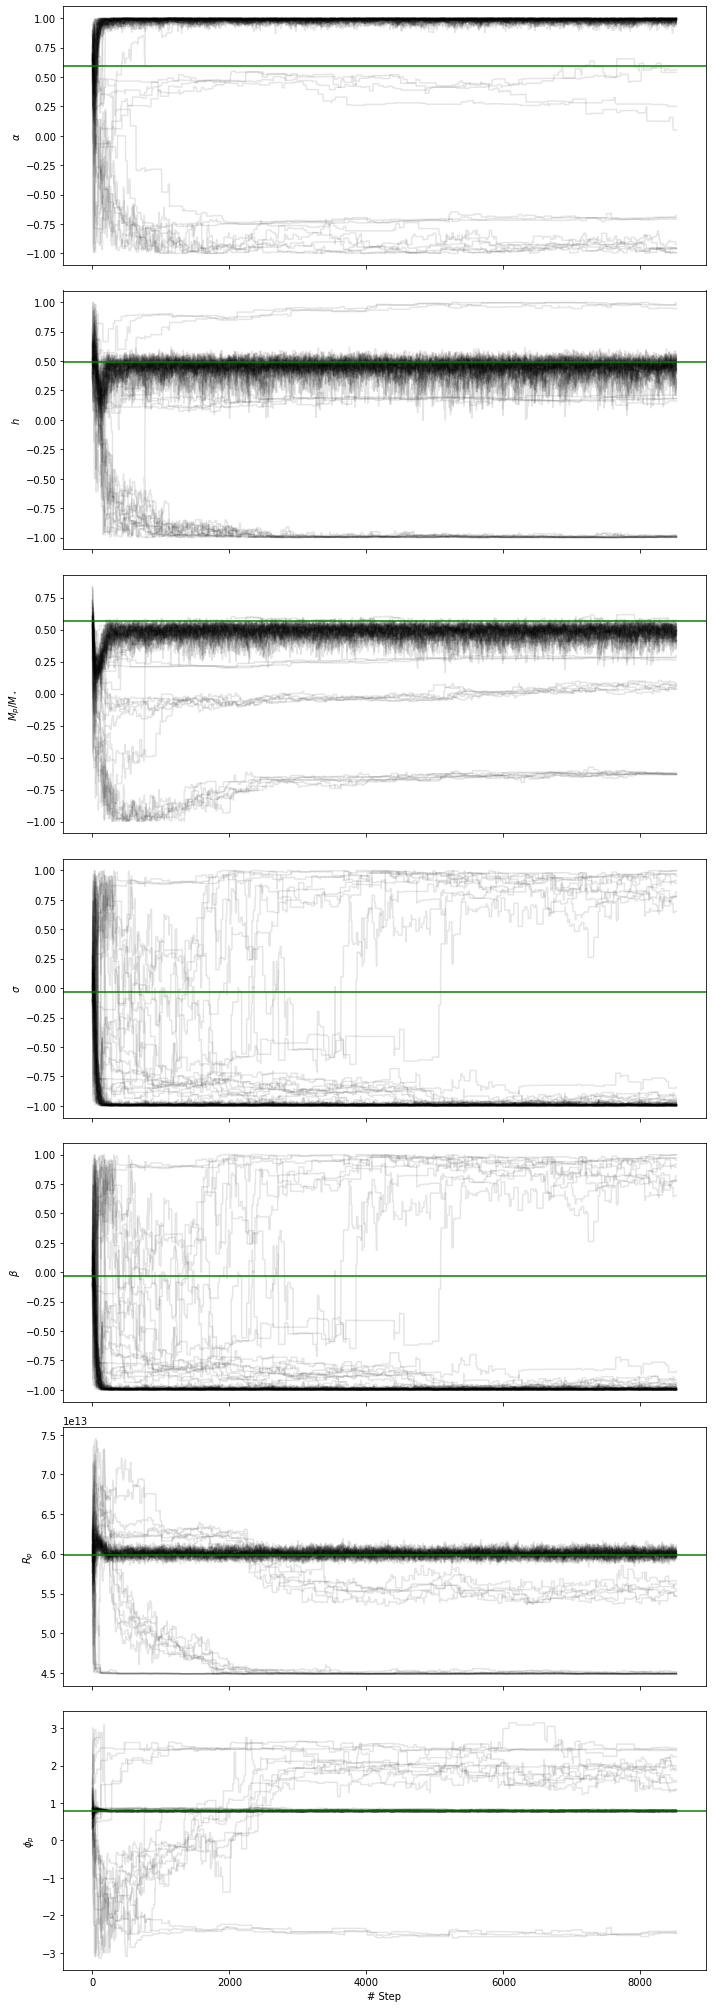

In [19]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(7, 1, figsize=(10,4*7), sharex=True)

for i in range(7):
    axs[i].plot(chain[:,:,i], color='black', alpha=0.1)
    axs[i].set_ylabel(labels[i])
    axs[i].axhline(target_params[i], color='g')
axs[-1].set_xlabel('# Step')
fig.tight_layout()
plt.savefig(f'{name}_chain.png', bbox_inches='tight', dpi=500)

# Likelihood

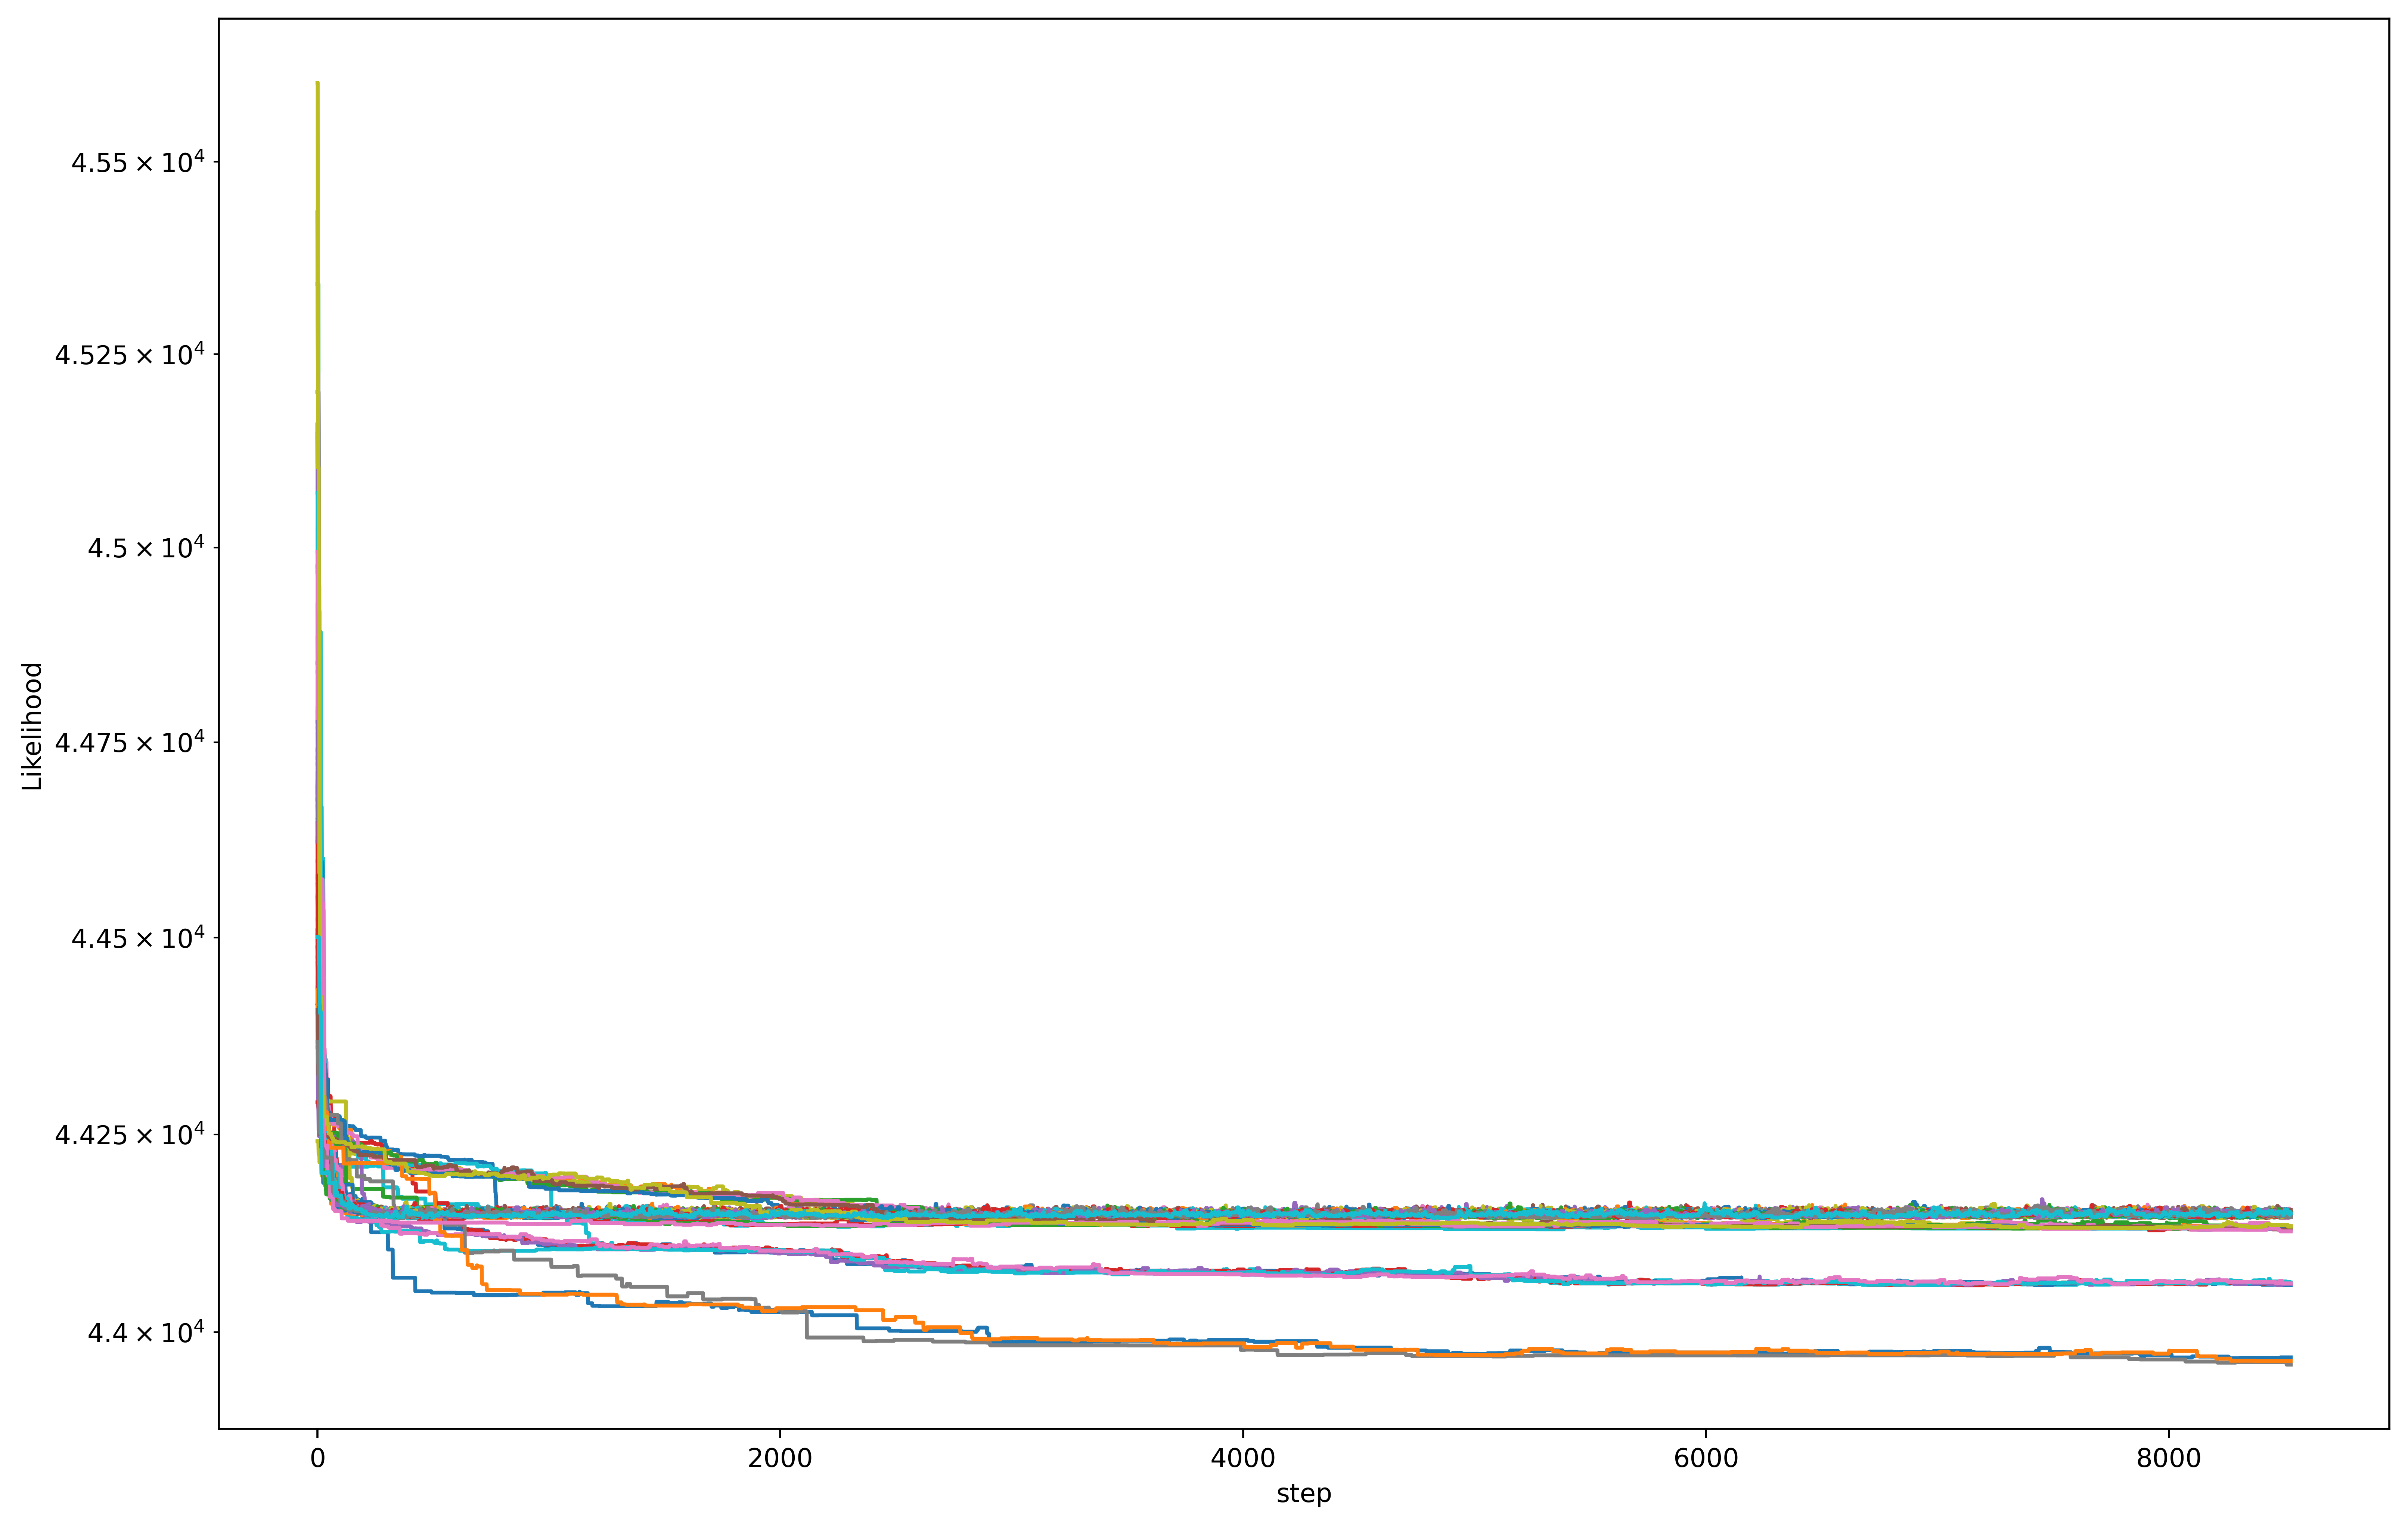

In [21]:
plt.plot(-reader.get_log_prob()[:,:])
plt.yscale('log')
plt.ylabel('Likelihood')
plt.xlabel('step')
plt.gcf().set_size_inches(15,10)
plt.gcf().set_dpi(500)
#plt.ylim(4.2e4,4.205e4)
#plt.xlim(125,200)

/tmp/ipykernel_23276/6733229.py:7: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(chain_flat[:,i], likelihood, marker='.', c=np.log10(np.arange(len(likelihood))))


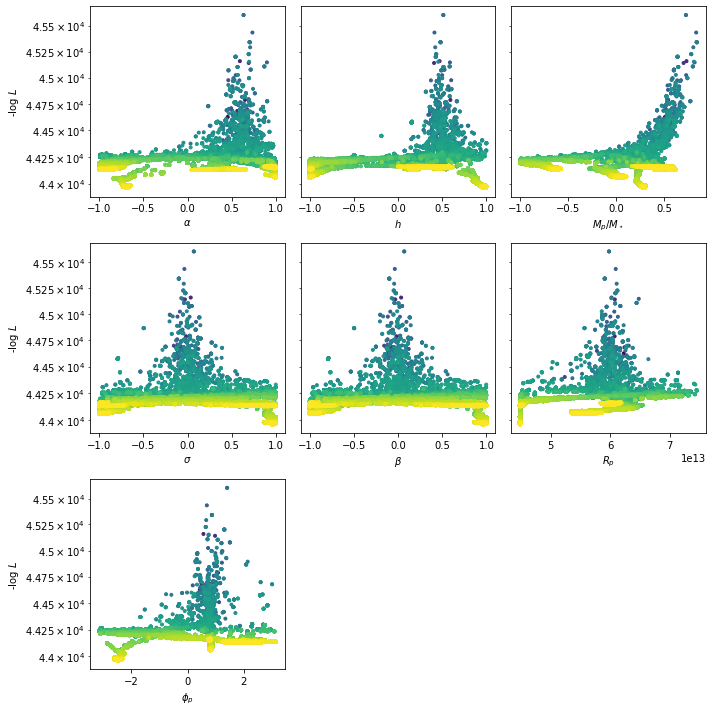

In [25]:
fig, axs = plt.subplots(3,3, figsize=(10,10), sharey=True)
chain_flat = chain.reshape(-1,7)
likelihood = -reader.get_log_prob().reshape(-1)
for i, ax, in enumerate(axs.flatten()):
    
    if i < 7:
        ax.scatter(chain_flat[:,i], likelihood, marker='.', c=np.log10(np.arange(len(likelihood))))
        ax.set_yscale('log')
        #ax.set_ylim(4.195e4, 4.24e4)
        ax.set_xlabel(labels[i])
    else:
        ax.axis('off')
        
    if i%3==0:
        ax.set_ylabel('-log $L$')
        
plt.tight_layout()
plt.savefig(f'{name}_logL.png', bbox_inches='tight', dpi=500)
